SciANN-Burgers.ipynb

An illustrain to use SciANN to solve Burgers problem introduced in: https://arxiv.org/pdf/1711.10561.pdf

For additional details, please check our paper at: https://arxiv.org/abs/2005.08803

Created by Ehsan Haghighat on 5/01/20.


In [1]:
# You need to have tensorflow, keras, and sciann installed in your system. 
# On google cloud, uncomment next line to install sciann. 

# !pip install sciann 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import sciann as sn 

Using TensorFlow backend.


--------------------- SCIANN 0.4.5.2 --------------------- 
Please review the documentation at "https://www.sciann.com". 
@misc{haghighat2019sciann, 
    title={SciANN: A Keras wrapper for scientific computations and physics-informed deep learning using artificial neural networks}, 
    author={Haghighat, Ehsan and Juanes, Ruben}, 
    url={https://github.com/sciann/sciann.git}, 
    year={2019} 
} 
----------------------------------------------------------


# Burgers problem

The governing equation is: 
$$
  u_{,t} + u u_{,x} - (0.01 / \pi) u_{,xx} = 0, \quad t \in [0, 1], \quad x \in [-1,1]
$$
subjected to 
$$
u(t=0, x) = -\sin(\pi x), \quad u(t, x=\pm 1) = 0
$$

The objective is to solve this equation with PINN. 

## Step 1: Setting up the neural network

The first step is to construct the approximation space. 

The independent variables are: $(t, x)$
The field variable is: $u(t, x)

The neural network approximation is defined as:
$$
\hat{u}: (t, x) \mapsto \mathcal{N}_u(t,x; \mathbf{W}, \mathcal{b})
$$

Here, we use 8 hidden layers with 20 neural units and hyperbolic-tangent activation function. 

In [3]:
x = sn.Variable('x')
t = sn.Variable('t')
u = sn.Functional('u', [t,x], 8*[20], 'tanh')

## Step 2: Setting up the optimzation problem

The second step is to set up the optimization model using SciModel interface. Input variables are $(t, x)$ and targets are:

*   $L_1 : ~~ u_{,t} + u u_{,x} - (0.01 / \pi) u_{,xx}$

In [4]:
from numpy import pi
from sciann.utils.math import diff, sign, sin

In [5]:
L1 = diff(u, t) + u*diff(u,x) - (0.01/pi)*diff(u, x, order=2)

Boundary conditions are: 
*   $C_1: ~~ (1+sign(0 - t))~(u + \sin(\pi x)$
*   $C_2: ~~ (1+sign(-1 - x))~u$
*   $C_3: ~~ (1+sign(x - 1))~u$


In [6]:
TOL = 0.001
C1 = (1-sign(t - TOL)) * (u + sin(pi*x))
C2 = (1-sign(x - (-1+TOL))) * (u)
C3 = (1+sign(x - ( 1-TOL))) * (u)

The "SciModel" with multiple objects is now defined as:

In [7]:
m = sn.SciModel([x, t], [L1, C1, C2, C3])

## Sampling (collocation) grid 

To train the network, we need to define a sampling (collocation) grid.

In [8]:
x_data, t_data = np.meshgrid(
    np.linspace(-1, 1, 100), 
    np.linspace(0, 1, 100)
)

## Training

We can then proform the training: 

In [9]:
h = m.train([x_data, t_data], 4*['zero'], learning_rate=0.002, epochs=5000, verbose=0)


Epoch 00656: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 01655: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 02654: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 03844: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 03983: early stopping


## Testing 

There are two ways to evaluate the functionals. 

1- eval without passing the model:
* Not suggested - the data should be provided in the same order as it was defined in the functional: "u = sn.Functional('u', [t,x], 8*[20], 'tanh')"
* u.eval([t_data, x_data])

2- eval with model (suggested): 
* the data should be provided in the same order as it was defined in the SciModel: "m = sn.SciModel([x, t], [L1, C1, C2, C3])"
* u.eval(m, [x_data, t_data]) 

In [10]:
x_test, t_test = np.meshgrid(
    np.linspace(-1, 1, 200), 
    np.linspace(0, 1, 200)
)
u_pred = u.eval(m, [x_test, t_test])

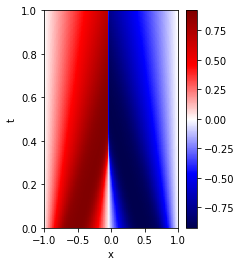

In [11]:
fig = plt.figure(figsize=(3, 4))
plt.pcolor(x_test, t_test, u_pred, cmap='seismic')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()